In [1]:
%autosave 10

Autosaving every 10 seconds


In [2]:
import urllib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from collections import defaultdict
import warnings
import geopandas
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
# Read CSV files
yellow_15_list = []
temp_15_list = []
for month in range(1,13):
    yellow_15_list.append(pd.read_csv(f'yellow_tripdata_2015-{month:02}.csv'))
    temp_15_list.append(pd.read_csv(f'2015-{month:02}.csv'))

In [4]:
# Convert date time
for month in range(12):
    yellow_15_list[month]['tpep_pickup_datetime'] =  pd.to_datetime(yellow_15_list[month]['tpep_pickup_datetime'])
    yellow_15_list[month]['tpep_dropoff_datetime'] =  pd.to_datetime(yellow_15_list[month]['tpep_dropoff_datetime'])

In [5]:
# Convert to lower case
for month in range(12):
     yellow_15_list[month] = yellow_15_list[month].rename(str.lower, axis = 'columns')

In [6]:
# Test for NAN
nan_rows = 0
total_rows = 0
for month in range(12):
    nan_rows += yellow_15_list[month][yellow_15_list[month].isnull().any(axis=1)].shape[0]
    total_rows += yellow_15_list[month].shape[0]
    yellow_15_list[month] = yellow_15_list[month].dropna()
    
print(f'The inital amount data of 2015 is {total_rows}.')
print(f'The missing data of 2015 is {nan_rows}.')

The inital amount data of 2015 is 146112989.
The missing data of 2015 is 3.


In [7]:
for month in range(12):
    # Calculate trip duration
    timediff = yellow_15_list[month].tpep_dropoff_datetime-yellow_15_list[month].tpep_pickup_datetime
    yellow_15_list[month]['duration'] = timediff / np.timedelta64(1, 'm')
    # Calculate speed
    yellow_15_list[month]['speed'] = yellow_15_list[month]['trip_distance'] / (yellow_15_list[month]['duration'] / 60)
    # Calculate money per mile
    yellow_15_list[month]['price_per_mile'] = yellow_15_list[month]['fare_amount'] / (yellow_15_list[month]['trip_distance'])
    #
    yellow_15_list[month]['except_tip'] = yellow_15_list[month]['total_amount'] - yellow_15_list[month]['tip_amount']

# Data Preprocessing

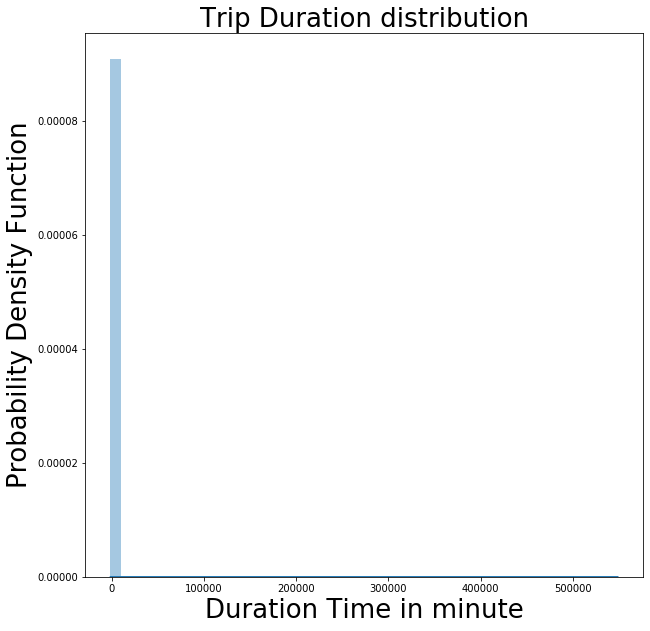

In [8]:
fig, ax = plt.subplots(figsize = (10,10))
sns.distplot(yellow_15_list[0]['duration'], bins = 50)

ax.set_title(f'Trip Duration distribution', fontsize = 26)
ax.set_xlabel('Duration Time in minute', fontsize = 26)
ax.set_ylabel('Probability Density Function', fontsize = 26)

plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
fig.savefig('Pre-processing: Trip Duration distribution.jpg')

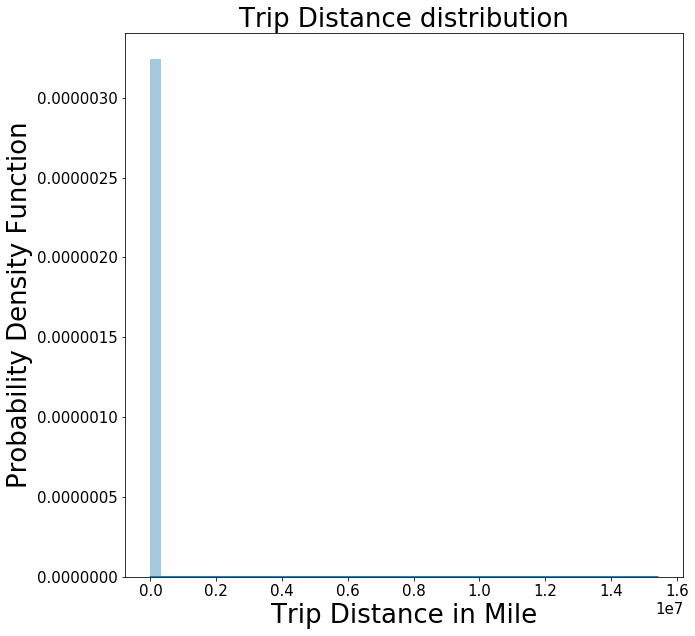

In [9]:
fig, ax = plt.subplots(figsize = (10,10))
sns.distplot(yellow_15_list[0]['trip_distance'], bins = 50)

ax.set_title(f'Trip Distance distribution', fontsize = 26)
ax.set_xlabel('Trip Distance in Mile', fontsize = 26)
ax.set_ylabel('Probability Density Function', fontsize = 26)

plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
fig.savefig('Pre-processing: Trip Distance distribution.jpg')

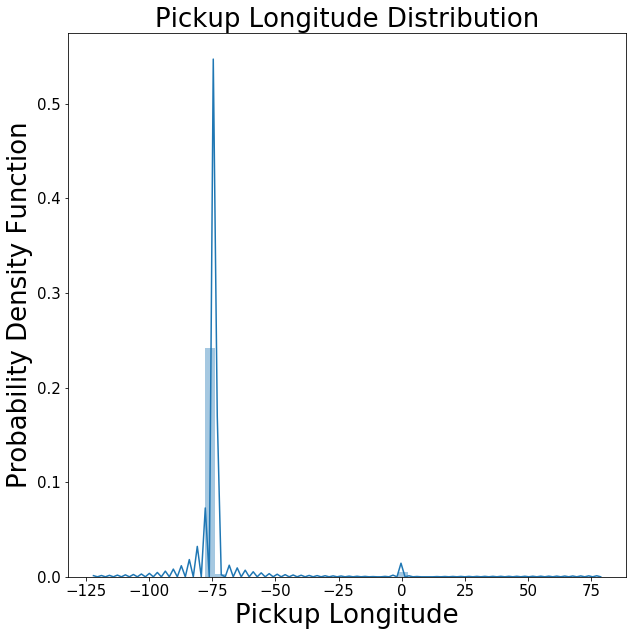

In [10]:
fig, ax = plt.subplots(figsize = (10,10))
sns.distplot(yellow_15_list[0]['pickup_longitude'], bins = 50)

ax.set_title(f'Pickup Longitude Distribution', fontsize = 26)
ax.set_xlabel('Pickup Longitude', fontsize = 26)
ax.set_ylabel('Probability Density Function', fontsize = 26)

plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
fig.savefig('Pre-processing: Pickup Longitude distribution.jpg')

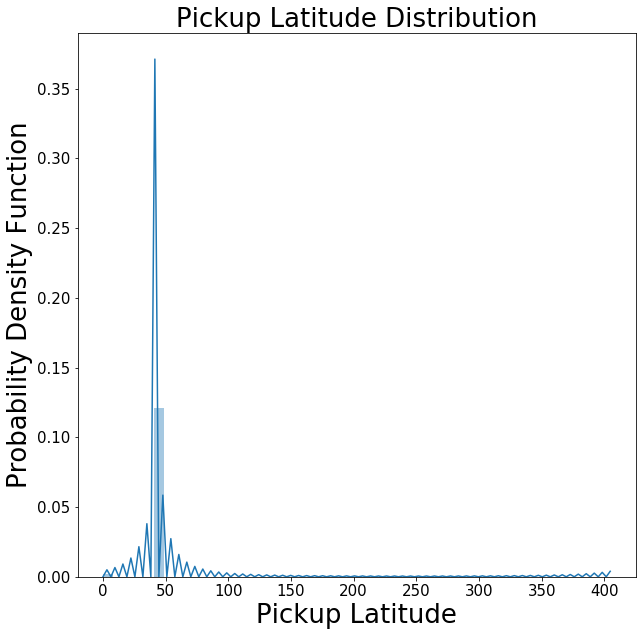

In [11]:
fig, ax = plt.subplots(figsize = (10,10))
sns.distplot(yellow_15_list[0]['pickup_latitude'], bins = 50)

ax.set_title(f'Pickup Latitude Distribution', fontsize = 26)
ax.set_xlabel('Pickup Latitude', fontsize = 26)
ax.set_ylabel('Probability Density Function', fontsize = 26)

plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
fig.savefig('Pre-processing: Pickup Latitude distribution.jpg')

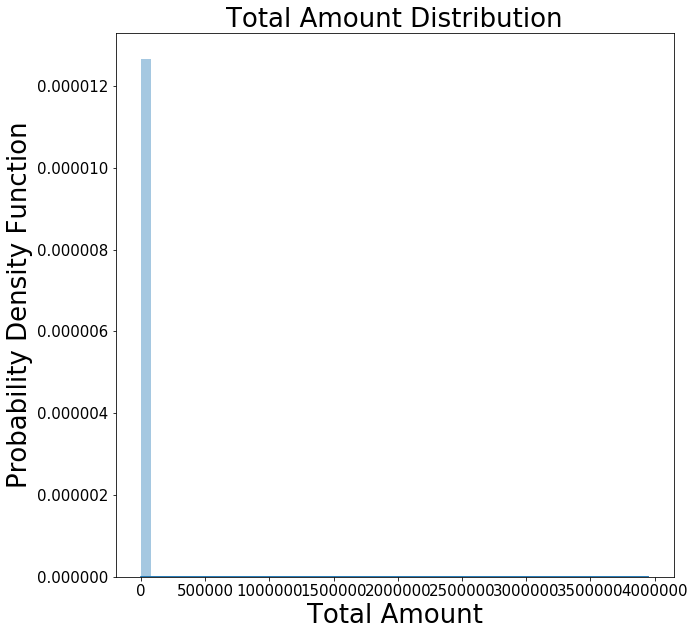

In [12]:
fig, ax = plt.subplots(figsize = (10,10))
total_amount_dis = sns.distplot(yellow_15_list[0]['total_amount'], bins = 50)

ax.set_title(f'Total Amount Distribution', fontsize = 26)
ax.set_xlabel('Total Amount', fontsize = 26)
ax.set_ylabel('Probability Density Function', fontsize = 26)

plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
fig.savefig('Pre-processing: Total Amount distribution.jpg')

In [13]:
# Test outlier for month
diff_month = 0
for month in range(12):
    diff_month += yellow_15_list[month][yellow_15_list[month]['tpep_pickup_datetime'].dt.month != month + 1].shape[0]
print(f'There are {diff_month} inconsistence caused by month values.')

# Test outlier for year
diff_year = 0
for month in range(12):
    diff_month += yellow_15_list[month][yellow_15_list[month]['tpep_pickup_datetime'].dt.year != 2015].shape[0]
print(f'There are {diff_year} inconsistence caused by year values.')

There are 0 inconsistence caused by month values.
There are 0 inconsistence caused by year values.


In [14]:
# Remove simple outliers
for month in range(12):
    # Remove passenger_count outliers
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].passenger_count <= 0].index)
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].passenger_count > 6].index)
    
    # Remove trip_distance outliers
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].trip_distance <= 0].index)
    
    # Remove RateCodeID outliers
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].ratecodeid > 6].index)
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].ratecodeid <= 0].index)
    
    # Remove extra outliers
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].extra < 0].index)
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].extra > 1.5].index)
    
    # Remove MTA_tax outliers
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][(yellow_15_list[month].mta_tax != 0) & (yellow_15_list[month].mta_tax != 0.5)].index)
    
    # Remove improvement_surcharge outliers
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][(yellow_15_list[month].improvement_surcharge != 0) & (yellow_15_list[month].improvement_surcharge != 0.3)].index)
    
    # Remove payment outliers
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].payment_type > 6].index)
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].payment_type <= 0].index)

    # Remove total_amount outliers
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].total_amount <= 0].index)

In [15]:
# Remove outliers
for month in range(12):
    # Remove speed outliers
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].speed > 65].index)
    
    # Remove duration outliers
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].duration <= 0].index)
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].duration > 180].index)
    
    # Remove price_per_mile outliers
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][(yellow_15_list[month].price_per_mile / 5) <= 0].index)
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][(yellow_15_list[month].price_per_mile / 5) > 3].index)
    
    # Remove tip outliers
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].tip_amount < 0].index)
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].tip_amount > 0.2 * yellow_15_list[month].except_tip].index)
    
    # Remove pickup latitude outliers
    longitude_range = [-74.257159, -73.699215]
    latitude_range = [40.495992, 40.915568]
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].pickup_latitude < latitude_range[0]].index)
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].pickup_latitude > latitude_range[1]].index)
    # Remove dropoff latitude outliers
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].dropoff_latitude < latitude_range[0]].index)
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].dropoff_latitude > latitude_range[1]].index)
    # Remove pickup longitude outliers
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].pickup_longitude < longitude_range[0]].index)
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].pickup_longitude > longitude_range[1]].index)
    # Remove dropoff longitude outliers
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].dropoff_longitude < longitude_range[0]].index)
    yellow_15_list[month] = yellow_15_list[month].drop(yellow_15_list[month][yellow_15_list[month].dropoff_longitude > longitude_range[1]].index)

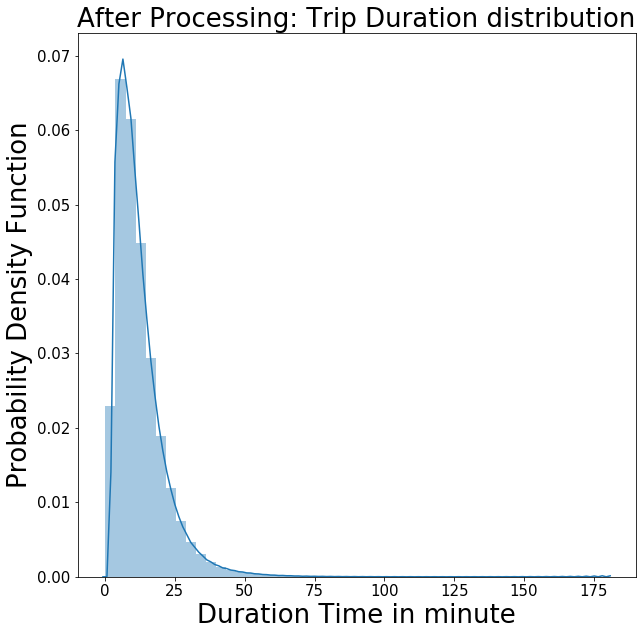

In [16]:
fig, ax = plt.subplots(figsize = (10,10))
sns.distplot(yellow_15_list[0]['duration'], bins = 50)

ax.set_title(f'After Processing: Trip Duration distribution', fontsize = 26)
ax.set_xlabel('Duration Time in minute', fontsize = 26)
ax.set_ylabel('Probability Density Function', fontsize = 26)

plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
fig.savefig('After Processing: Trip Duration distribution.jpg')

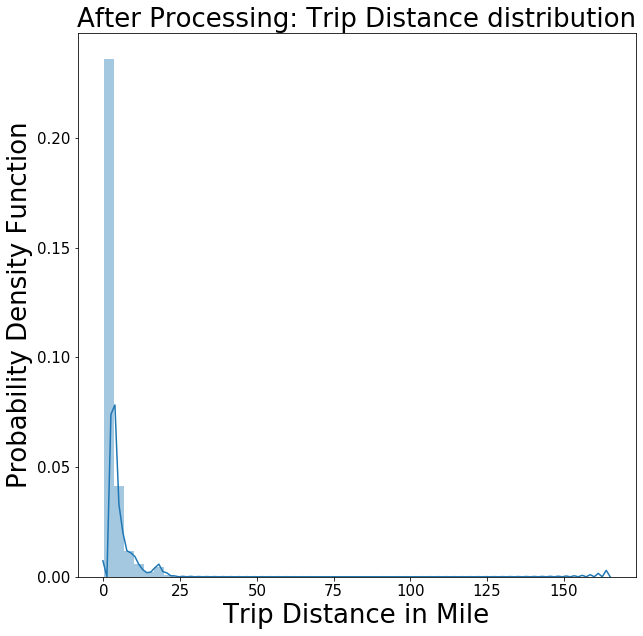

In [17]:
fig, ax = plt.subplots(figsize = (10,10))
sns.distplot(yellow_15_list[0]['trip_distance'], bins = 50)

ax.set_title(f'After Processing: Trip Distance distribution', fontsize = 26)
ax.set_xlabel('Trip Distance in Mile', fontsize = 26)
ax.set_ylabel('Probability Density Function', fontsize = 26)

plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
fig.savefig('After Processing: Trip Distance distribution.jpg')

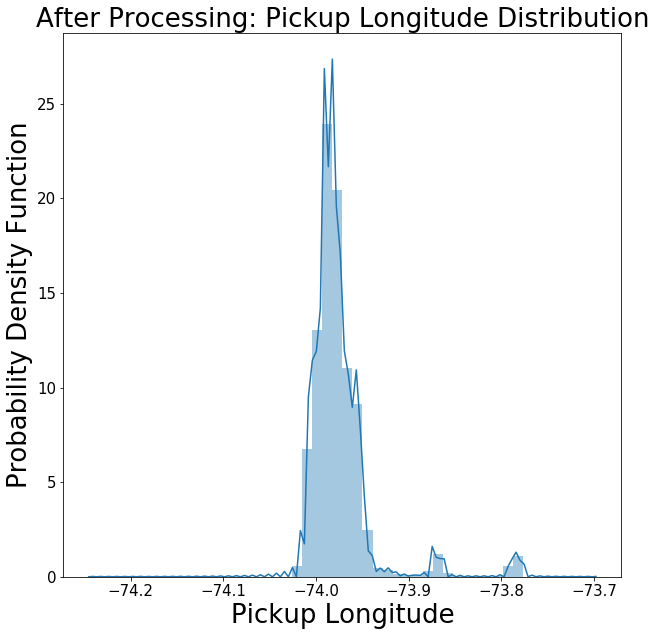

In [18]:
fig, ax = plt.subplots(figsize = (10,10))
sns.distplot(yellow_15_list[0]['pickup_longitude'], bins = 50)

ax.set_title(f'After Processing: Pickup Longitude Distribution', fontsize = 26)
ax.set_xlabel('Pickup Longitude', fontsize = 26)
ax.set_ylabel('Probability Density Function', fontsize = 26)

plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
fig.savefig('After Processing: Pickup Longitude distribution.jpg')

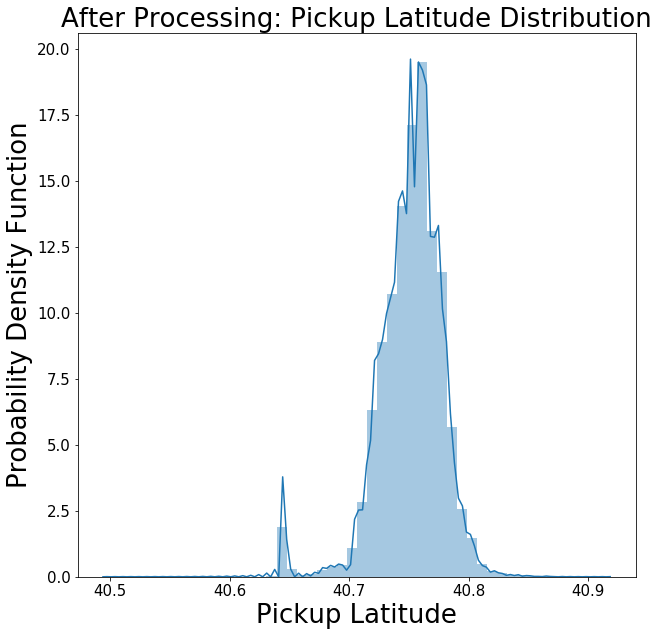

In [19]:
fig, ax = plt.subplots(figsize = (10,10))
sns.distplot(yellow_15_list[0]['pickup_latitude'], bins = 50)

ax.set_title(f'After Processing: Pickup Latitude Distribution', fontsize = 26)
ax.set_xlabel('Pickup Latitude', fontsize = 26)
ax.set_ylabel('Probability Density Function', fontsize = 26)

plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
fig.savefig('After Processing: Pickup Latitude distribution.jpg')

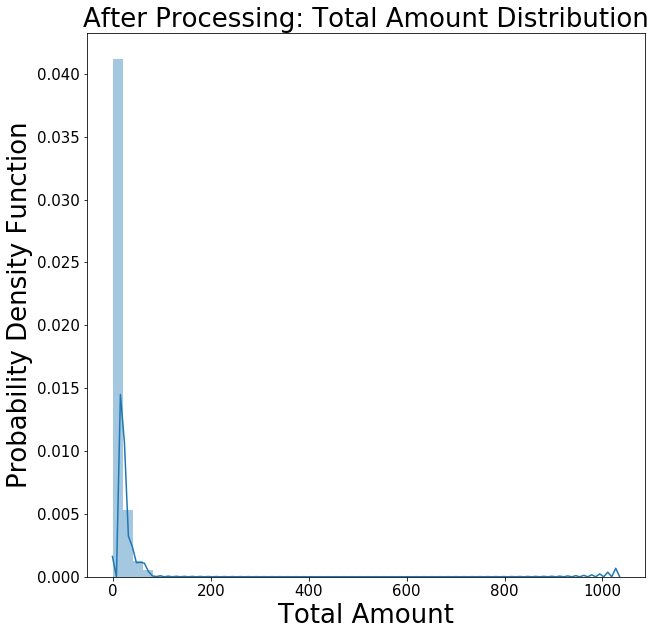

In [20]:
fig, ax = plt.subplots(figsize = (10,10))
total_amount_dis = sns.distplot(yellow_15_list[0]['total_amount'], bins = 50)

ax.set_title(f'After Processing: Total Amount Distribution', fontsize = 26)
ax.set_xlabel('Total Amount', fontsize = 26)
ax.set_ylabel('Probability Density Function', fontsize = 26)

plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
fig.savefig('After Processing: Total Amount distribution.jpg')

# Feature to Analyze

In [21]:
overview_list = []
for month in range(12):
    overview_list.append(yellow_15_list[month][['tpep_pickup_datetime', 'tpep_dropoff_datetime',
        'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']])

In [22]:
for month in range(12):
    # Calculate exact date / date (exact date)
    overview_list[month]['dayofyear'] = overview_list[month]['tpep_pickup_datetime'].dt.date
    # Calculate month (1-12)
    overview_list[month]['month'] = overview_list[month]['tpep_pickup_datetime'].dt.month
    # Calculate day (MON-SUN)
    overview_list[month]['dayofweek'] = overview_list[month]['tpep_pickup_datetime'].dt.dayofweek + 1
    # Calculate time (0-23)
    overview_list[month]['time'] = overview_list[month]['tpep_pickup_datetime'].dt.hour
    # drop
    overview_list[month].drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

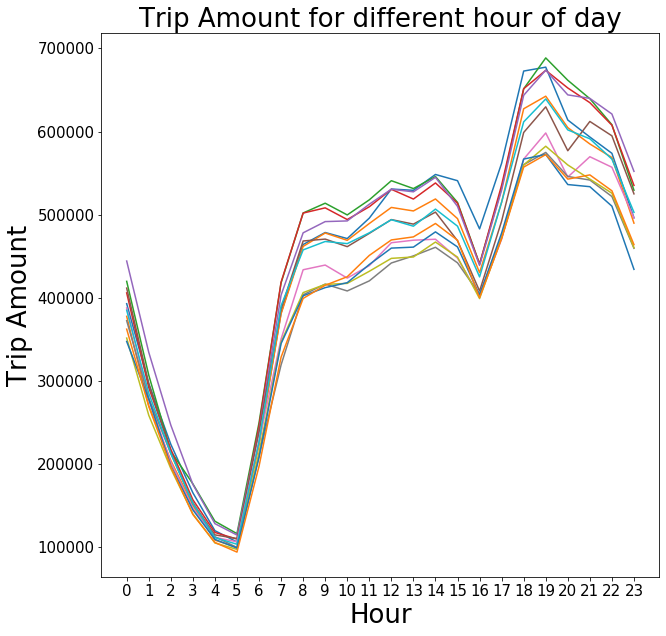

In [23]:
# plot by hour order amounts
fig, ax = plt.subplots(figsize = (10,10))
plt.xticks(np.arange(0, 24, 1.0))
for month in range(12):
    time_plot = overview_list[month].groupby('time').size()       
    plt.plot(time_plot)
    
ax.set_title(f'Trip Amount for different hour of day', fontsize = 26)
ax.set_xlabel('Hour', fontsize = 26)
ax.set_ylabel('Trip Amount', fontsize = 26)
plt.rc('xtick',labelsize = 20)
plt.rc('ytick',labelsize = 20)
fig.savefig('Overview:trip_amount vs hour_of_day.jpg')

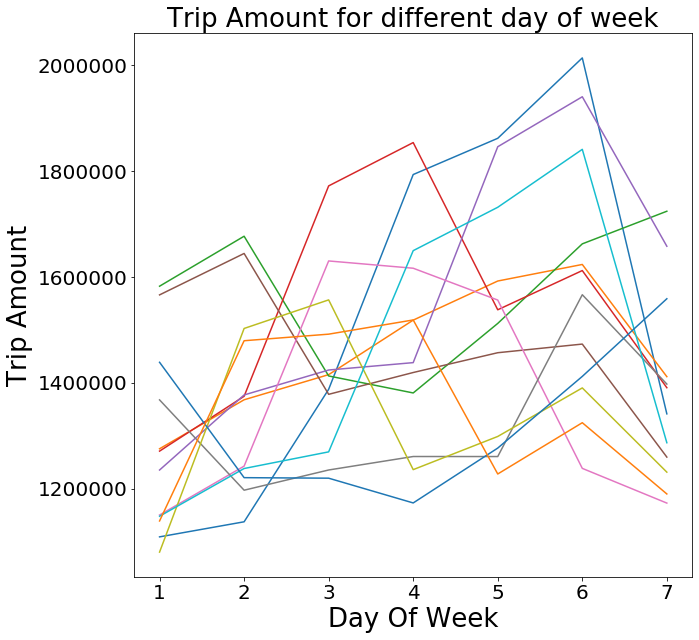

In [24]:
# plot by day of week
fig, ax = plt.subplots(figsize = (10,10))
for month in range(12):
    dayofweek_plot = overview_list[month].groupby('dayofweek').size()       
    plt.plot(dayofweek_plot)

ax.set_title(f'Trip Amount for different day of week', fontsize = 26)
ax.set_xlabel('Day Of Week', fontsize = 26)
ax.set_ylabel('Trip Amount', fontsize = 26)
plt.rc('xtick',labelsize = 20)
plt.rc('ytick',labelsize = 20)
fig.savefig('Overview:trip_amount vs day_of_week.jpg')

In [ ]:
# plot by exact date
fig, ax = plt.subplots(figsize = (10,10))
for month in range(12):
    daily_plot = overview_list[month].groupby('dayofyear').size()       
    plt.plot(daily_plot)
    
ax.set_title(f'Trip Amount for different day of year', fontsize = 26)
ax.set_xlabel('Day Of Year', fontsize = 26)
ax.set_ylabel('Trip Amount', fontsize = 26)
plt.rc('xtick',labelsize = 12)
plt.rc('ytick',labelsize = 16)
fig.savefig('Overview:trip_amount vs day_of_year.jpg')

In [ ]:
overview_15 = pd.concat(overview_list)
everyday = pd.DataFrame(overview_15.groupby('dayofyear').size())
everyday['dayofyear'] = everyday.index
everyday.nsmallest(5, columns = 0)

# Overview

In [ ]:
# sample data
small_sample = overview_15.sample(int(0.01*(overview_15.shape[0])), random_state = 42)

plt.figure(figsize=(20,20))

plt.hexbin(x = small_sample['pickup_longitude'], y= small_sample['pickup_latitude'],
           gridsize=100, bins='log', cmap='inferno')

plt.xlabel('Longitude', fontsize = 26)
plt.ylabel('Latitude', fontsize = 26)
plt.title('Trip Count vs Pick-up Location', fontsize = 26)
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.show()
fig.savefig('Overview: Trip Count vs Pick-up Location.jpg')

In [ ]:
# pick up location (heatmap)
PICKUP = ['pickup_latitude', 'pickup_longitude']
nycM = folium.Map(location = [40.66, -73.94], tiles = "Stamen Terrain", zoom_start = 10)
nycM.add_child(HeatMap(small_sample[PICKUP].values, radius=10))

folium.Marker([40.645311, -73.784418], popup ='JFK airport', icon = folium.Icon(color = 'black')).add_to(nycM)
folium.Marker([40.769657, -73.864455], popup ='LaGuardia airport',icon = folium.Icon(color = 'black')).add_to(nycM)
folium.Marker([40.687234, -74.178881], popup ='Newark airport', icon = folium.Icon(color = 'black')).add_to(nycM)
folium.Marker([40.7502, -73.9931], popup ='Penn Station', icon = folium.Icon(color = 'red')).add_to(nycM)
folium.Marker([40.752726,  -73.977229], popup ='Grand Central Terminal', icon = folium.Icon(color='red')).add_to(nycM)
nycM.save('Pickup location overview.html')

In [ ]:
# create an interactive geospatial graph
nycM1 = folium.Map(location = [40.66, -73.94], tiles = "Stamen Terrain", zoom_start = 10)

# use a built-in clustering algorithm to apply markers for hotspots
FastMarkerCluster(data = small_sample[PICKUP]).add_to(nycM1)
folium.Marker([40.645311, -73.784418], popup = 'JFK airport', icon = folium.Icon(color = 'black')).add_to(nycM1)
folium.Marker([40.769657, -73.864455], popup ='LaGuardia airport',icon = folium.Icon(color = 'black')).add_to(nycM1)
folium.Marker([40.687234, -74.178881], popup ='Newark airport', icon = folium.Icon(color = 'black')).add_to(nycM1)
folium.Marker([40.7502, -73.9931], popup = 'Penn Station', icon = folium.Icon(color = 'red')).add_to(nycM1)
folium.Marker([40.752726,  -73.977229], popup = 'Grand Central Terminal', icon = folium.Icon(color='red')).add_to(nycM1)
nycM1.save('Pickup location overview with number.html')

# Q1: Hour VS Airport Trip VS Tip Amount Analysis 

In [ ]:
# Construct useful attributes
question1_list = []
for month in range(12):
    question1_list.append(yellow_15_list[month][['duration', 'tpep_pickup_datetime', 
        'tpep_dropoff_datetime', 'trip_distance', 'ratecodeid', 'payment_type', 'tip_amount', 
        'fare_amount', 'speed']])

In [ ]:
# Create useful attributes
for month in range(12): 
    # Calculate time (0-23)
    question1_list[month]['time'] = question1_list[month]['tpep_pickup_datetime'].dt.hour
    # drop
    question1_list[month].drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

In [ ]:
# merge data
question1_15 = pd.concat(question1_list)
question1_15 = question1_15.sample(int(0.2*question1_15.shape[0]), random_state = 42)

# Airport or not
airport_df = question1_15[(question1_15['ratecodeid'] == 2) | (question1_15['ratecodeid'] == 3)]
airport_df['airport'] = 'Airport'

not_airport_df = question1_15[(question1_15['ratecodeid'] != 2) & (question1_15['ratecodeid'] != 3)]
not_airport_df['airport'] = 'Not Airport'

In [ ]:
# calculate percentage
plot1 = airport_df.groupby('time').size()  
plot2 = not_airport_df.groupby('time').size()  

airport_plot = []
noairport_plot = []
for i in range(24):
    airport_plot.append(plot1[i] / (plot1[i] + plot2[i]))
    noairport_plot.append(plot2[i] / (plot1[i] + plot2[i]))

In [ ]:
# airport percentage plot

fig, ax = plt.subplots(figsize = (10,10))
plt.xticks(np.arange(0, 24, 1.0))

ind = np.arange(24) 
width = 0.15       
plt.bar(ind, airport_plot, width, label = 'Airport')
plt.bar(ind + width, noairport_plot, width, label = 'Not Airport')
plt.xlabel('Hour', fontsize = 26)
plt.ylabel('Percentage', fontsize = 26)
plt.title('Airport trip percentage vs non-airport trip percentage')
plt.legend(loc = 'best')
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.show()
fig.savefig('Q1:trip_percentage vs ariport.jpg')

In [ ]:
# airport plot

fig, ax = plt.subplots(figsize=(10,10))
plt.xticks(np.arange(0, 24, 1.0))

ind = np.arange(24) 
width = 0.15       
plt.bar(ind, plot1, width, label = 'Airport')
plt.bar(ind + width, plot2, width, label = 'Not Airport')

plt.xlabel('Hour', fontsize = 26)
plt.ylabel('Trip Amount', fontsize = 26)
plt.title('Airport trip amount vs non-airport trip amount')
plt.legend(loc = 'best')
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.show()
fig.savefig('Q1:trip_amount vs ariport.jpg')

In [ ]:
# drop non credit card
airport_df = airport_df.drop(airport_df[airport_df.payment_type != 1].index)
not_airport_df = not_airport_df.drop(not_airport_df[not_airport_df.payment_type != 1].index)
question1_15 = pd.concat([not_airport_df, airport_df])

In [ ]:
# tip-hour-airport boxplot
fig, ax = plt.subplots(figsize = (20,20))
sns.boxplot(x = 'time', y = 'tip_amount', hue = "airport", data = question1_15)

ax.set_title(f'Total tip amount for different hour time for airport trip or non-airport trip', fontsize = 26)
ax.set_xlabel('Hour', fontsize = 26)
ax.set_ylabel('Total Tip Amount', fontsize = 26)
ax.legend(prop = dict(size = 26), loc = 'best')
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
fig.savefig('Q1:total_tip vs hour vs ariport.jpg')

In [ ]:
# tippermin-hour-airport
question1_15['tip_per_min'] = question1_15['tip_amount'] / question1_15['duration']

q1 = question1_15['tip_per_min'].quantile(0.25)
q3 = question1_15['tip_per_min'].quantile(0.75)
IQR = q3-q1
question1_15_copy = question1_15.copy()
question1_15_copy = question1_15_copy.drop(question1_15_copy[(question1_15_copy.tip_per_min > q3 + 6*IQR) | (question1_15_copy.tip_per_min < q1 - 2*IQR)].index)

fig, ax = plt.subplots(figsize=(20,20))
sns.boxplot(x ='time', y = 'tip_per_min', hue = "airport", data = question1_15_copy)

ax.set_title(f'Tip per minute for different hour time for airport trip or non-airport trip', fontsize = 26)
ax.set_xlabel('Hour', fontsize = 26)
ax.set_ylabel('Tip Per Minute', fontsize = 26)
ax.legend(prop = dict(size = 18), loc = 'best')
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
fig.savefig('Q1:tip_per_min vs hour vs ariport.jpg')

In [ ]:
# tippermile-hour-airport
question1_15['tip_per_mile'] = question1_15['tip_amount'] / question1_15['trip_distance']

q1 = question1_15['tip_per_mile'].quantile(0.25)
q3 = question1_15['tip_per_mile'].quantile(0.75)
IQR = q3-q1
question1_15_copy = question1_15.copy()
question1_15_copy = question1_15_copy.drop(question1_15_copy[(question1_15_copy.tip_per_mile > q3 + 6*IQR) | (question1_15_copy.tip_per_mile < q1 - 2*IQR)].index)


fig, ax = plt.subplots(figsize = (20,20))
sns.boxplot(x = 'time', y = 'tip_per_mile', hue = "airport", data = question1_15_copy)

ax.set_title(f'Tip per mile for different hour time for airport trip or non-airport trip', fontsize = 26)
ax.set_xlabel('Hour', fontsize = 26)
ax.set_ylabel('Tip Per Mile', fontsize = 26)
ax.legend(prop = dict(size = 18), loc = 'best')
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
fig.savefig('Q1:tip_per_mile vs hour vs ariport.jpg')

In [ ]:
# speed-hour-airport


fig, ax = plt.subplots(figsize=(20,20))
sns.boxplot(x = 'time', y = 'speed', hue = "airport", data = question1_15)

ax.set_title(f'Speed for different hour time for airport trip or non-airport trip', fontsize = 26)
ax.set_xlabel('Hour', fontsize = 26)
ax.set_ylabel('Speed', fontsize = 26)
ax.legend(prop = dict(size = 26))
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
fig.savefig('Q1:speed vs hour vs ariport.jpg')

In [ ]:
# speed-hour-airport

fig, ax = plt.subplots(figsize=(20,20))
sns.boxplot(x = 'time', y = 'trip_distance', hue = "airport", data = question1_15)

ax.set_title(f'Distance for different hour time for airport trip or non-airport trip', fontsize = 26)
ax.set_xlabel('Hour', fontsize = 26)
ax.set_ylabel('Trip Distance', fontsize = 26)
ax.legend(prop = dict(size = 26))
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
fig.savefig('Q1:distance vs hour vs ariport.jpg')

In [ ]:
question1_15['factorize_airport'] = pd.factorize(question1_15['airport'])[0]

fig, ax = plt.subplots(figsize = (8,8))
corr = question1_15[['tip_amount', 'tip_per_min', 'tip_per_mile', 
                     'factorize_airport', 'time', 'speed', 'trip_distance', 'duration']].corr()
sns.heatmap(corr, annot = True)

plt.title('Correlation between attributes')
fig = plt.gcf()
plt.show()
fig.savefig('Q1: Correlation between attributes .jpg')

# Q2: Passenger Count VS Week of Day VS Tip Amount

In [ ]:
# Construct useful attributes
question2_list = []
for month in range(12):
    question2_list.append(yellow_15_list[month][['duration', 'tpep_pickup_datetime', 
        'tpep_dropoff_datetime', 'passenger_count', 'ratecodeid', 'tip_amount',
        'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'speed']])

In [ ]:
# Create useful attributes
for month in range(12):
    # Calculate day (MON-SUN)
    question2_list[month]['dayofweek'] = question2_list[month]['tpep_pickup_datetime'].dt.dayofweek + 1
    # drop
    question2_list[month].drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

In [ ]:
question2_15 = pd.concat(question2_list)
question2_15 = question2_15.sample(int(0.01*question2_15.shape[0]), random_state = 42)

In [ ]:
# confrim they go to work 
question2_15 = question2_15.sort_values(by = 'dayofweek', ascending = True)
fig = px.density_mapbox(question2_15, lon = 'dropoff_longitude', lat = 'dropoff_latitude', 
                        z ='passenger_count',  radius = 2, center = dict(lat = 40.74, lon = -74), 
                        zoom=10, animation_frame = 'dayofweek', mapbox_style = 'open-street-map')
fig.write_html("Q2:Passenger Count VS Dayofweek VS Location.html")

In [ ]:
# drop non credit card
question2_15 = question2_15.drop(question2_15[question2_15.payment_type != 1].index)
# different moods (work, travel) and tip amounts
question2_15['tip_per_min'] = question2_15['tip_amount'] / question2_15['duration']
question2_15 = question2_15.sort_values(by='dayofweek', ascending = True)

fig = px.density_mapbox(question2_15, lon = 'dropoff_longitude', lat = 'dropoff_latitude', 
                        z ='tip_per_min',  radius = 2, center = dict(lat = 40.74, lon=-74), 
                        zoom=10, animation_frame = 'dayofweek', mapbox_style = 'open-street-map')
fig.write_html("Q2:Tip Per Minute VS Dayofweek VS Location.html")

In [ ]:
# work or not
work_df = question2_15[(question2_15['dayofweek'] != 6) & (question2_15['dayofweek'] != 7)]
work_df['work'] = 'Work'

not_work_df = question2_15[(question2_15['dayofweek'] == 6) | (question2_15['dayofweek'] == 7)]
not_work_df['work'] = 'Not Work'

question2_15 = pd.concat([not_work_df, work_df])
question2_15 = question2_15.drop(question2_15[question2_15.tip_per_min > 5].index)

In [ ]:
# weekday want high speed


fig, ax = plt.subplots(figsize = (20,20))


sns.scatterplot(x = 'speed', y = 'tip_per_min', hue = 'work', data = question2_15)
ax.set_title(f'Tip per minute for different speed on workday or on non-workday', fontsize = 26)
ax.set_xlabel('Speed', fontsize = 26)
ax.set_ylabel('Tip Per Minute', fontsize = 26)
ax.legend(prop = dict(size = 26))
plt.rc('xtick',labelsize = 20)
plt.rc('ytick',labelsize = 20)
fig.savefig('Q2:Tip Per Minute VS Speed VS Work.jpg')

# Q3 Rainy 

In [ ]:
# Construct useful attributes
question3_list = []
for month in range(12):
    question3_list.append(yellow_15_list[month][['duration', 'tpep_pickup_datetime', 
        'trip_distance', 'tip_amount', 'speed', 'payment_type']])

In [ ]:
for month in range(12):
    question3_list[month]['dayofyear'] = question3_list[month]['tpep_pickup_datetime'].dt.dayofyear
    question3_list[month]['date'] = question3_list[month]['tpep_pickup_datetime'].dt.day
    question3_list[month]['dayofweek'] = question3_list[month]['tpep_pickup_datetime'].dt.dayofweek + 1
    question3_list[month]['month'] = question3_list[month]['tpep_pickup_datetime'].dt.month
    question1_list[month].drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

In [ ]:
for month in range(12):
    # merge temperature
    question3_list[month] = pd.merge(question3_list[month], temp_15_list[month], left_on = "date", right_on="Time").drop('Time', axis=1)
    # Rain or not 
    question3_list[month]['Rain'] = (question3_list[month]['Precipitation'] != 0)

In [ ]:
question3_15 = pd.concat(question3_list)
question3_15 = question3_15.sample(int(0.2*question3_15.shape[0]), random_state = 42)

In [ ]:
rain_df = question3_15[question3_15['Rain'] == True]
not_rain_df = question3_15[question3_15['Rain'] == False]

# count rainy and not rainy day for each day 
rainy_days = []
not_rainy_days = []
for i in range(1,8):
    rainy_days.append(rain_df[rain_df['dayofweek'] == i]['dayofyear'].nunique())
    not_rainy_days.append(not_rain_df[not_rain_df['dayofweek'] == i]['dayofyear'].nunique())

In [ ]:
# construct dataframe 
rain_count = pd.DataFrame(rain_df.groupby('dayofweek').size())
rain_count['dayofweek'] = rain_count.index
rain_count['numofdays'] = rainy_days
rain_count['rain'] = 'Rainy Day'
not_rain_count = pd.DataFrame(not_rain_df.groupby('dayofweek').size())
not_rain_count['dayofweek'] = not_rain_count.index
not_rain_count['numofdays'] = not_rainy_days
not_rain_count['rain'] = 'Not Rainy Day'
# calculate percentage
rain_not_rain = pd.concat([not_rain_count, rain_count])
rain_not_rain['Averge Count Per Day'] = rain_not_rain[0] / rain_not_rain['numofdays']

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
ax = sns.barplot(x = 'dayofweek', y = 'Averge Count Per Day', hue = 'rain', data = rain_not_rain)
ax.set_title(f'Count of trips during the week with rain or not rain', fontsize = 26)
ax.set_xlabel('Dayofweek', fontsize = 26)
ax.set_ylabel('Averge Count Per Day', fontsize=26)
ax.legend(prop = dict(size = 26))
plt.rc('xtick',labelsize = 16)
plt.rc('ytick',labelsize = 16)
fig.savefig('Q3:Counts of trips during the week with rain or not rain.jpg')

In [ ]:
# distant - rain - payment boxplot
fig, ax = plt.subplots(figsize = (10,10))
sns.boxplot(x = 'dayofweek', y = 'speed', hue = "Rain", data = question3_15)

ax.set_title(f'Speed during the week with rain or without rain', fontsize = 26)
ax.set_xlabel('Day Of Week', fontsize = 26)
ax.set_ylabel('Speed', fontsize = 26)
ax.legend(prop = dict(size = 26))
plt.rc('xtick',labelsize = 16)
plt.rc('ytick',labelsize = 16)
fig.savefig('Q3:Speed vs week vs rain.jpg')

In [ ]:
rain_not_rain['factorize_rain'] = pd.factorize(rain_not_rain['rain'])[0]
question3_15['factorize_rain'] = pd.factorize(question3_15['Rain'])[0]


fig, ax = plt.subplots(figsize = (8,8))
corr = rain_not_rain[['dayofweek', 'Averge Count Per Day', 'factorize_rain',]].corr()
sns.heatmap(corr, annot = True)
plt.title('Correlation between attributes')
fig = plt.gcf()
plt.show()
fig.savefig('Q3.1: Correlation between attributes.jpg')


fig, ax = plt.subplots(figsize = (8,8))
corr = question3_15[['dayofweek', 'speed', 'factorize_rain',]].corr()
sns.heatmap(corr, annot = True)
plt.title('Correlation between attributes')
fig = plt.gcf()
plt.show()
fig.savefig('Q3.2: Correlation between attributes.jpg')